In [2]:
import numpy as np
#from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.cuda.is_available()

True

In [4]:
import scipy.io
mat = scipy.io.loadmat('Car_Dataset_hyst_10s_N1000_v3.mat')
RV = mat['param'].T 
tin = mat['t']
# # mat['resp_all'].shape
xlow_all = mat['accel_LF'].T 
# mat = scipy.io.loadmat('DeepONet_degrading_data_v2.mat')
#xhigh_all = mat['accel_HF'].T
xhigh_all = mat['disp_HF'].T

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'accel_HF', 'accel_LF', 'disp_HF', 'disp_LF', 'p_mean', 'p_var', 'param', 't'])

In [6]:
mat['param'].T.shape

(1000, 5)

In [7]:
mat = scipy.io.loadmat('road_surface.mat')
w1 = mat['w1'] 

In [8]:
w1.shape

(1, 601)

In [9]:
data_min = w1.min()
data_max = w1.max()

normalized_w1 = (w1 - data_min) / (data_max - data_min) * 2 - 1

In [10]:
xhigh_all.shape

(601, 1000)

In [11]:
tin.shape

(1, 601)

In [508]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 7

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = (w1[0,:])
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))
    
    for j in range(5): 
        io[i,:,2+j] = -1.0+2*(RV[i,j]*np.ones((nt,))-np.amin(RV[:,j]))/(np.amax(RV[:,j])-np.amin(RV[:,j])) 
   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = (-1.0+(xhigh_all[:,i]))/2.0 # For HF training

In [509]:
io.shape

(1000, 601, 7)

In [510]:
RV.shape

(1000, 5)

### Without Parameters

In [12]:
import os
from datetime import datetime
direct= os.path.join(os.getcwd(),'logs')
today_date = datetime.now().strftime('%Y-%m-%d')

In [13]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 2

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = normalized_w1[0,:]
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = (-1.0+(xhigh_all[:,i]))/2.0 # For HF training
    #op[i,:] = xhigh_all[:,i]
  

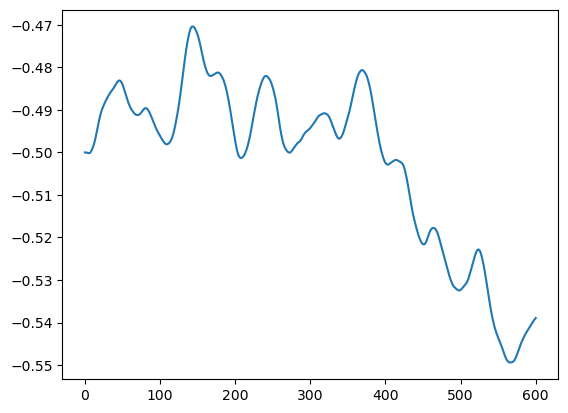

In [14]:
plt.plot(op[1,:])

In [15]:
op.shape

(1000, 601)

In [16]:
tin.shape

(1, 601)

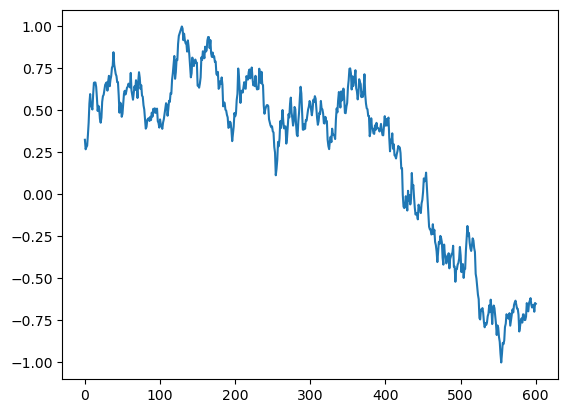

In [38]:
plt.plot(io[1,:,0])

In [39]:
io.shape

(1000, 601, 2)

In [40]:
op.shape

(1000, 601)

In [41]:
x_torch = torch.from_numpy(io).float()
y_torch = torch.from_numpy(op).float().unsqueeze(1)

In [17]:
x_torch_w1=torch.from_numpy(io[:,:,0]).float()

In [18]:
x_torch_w1.shape

torch.Size([1000, 601])

In [19]:
x_torch.shape

torch.Size([1000, 601, 2])

In [20]:
y_torch.shape

torch.Size([1000, 1, 601])

In [21]:
(y_torch[0,:,:].T).shape

torch.Size([601, 1])

In [42]:
model_car = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1),
    nn.BatchNorm1d(1)
)

In [15]:
device=torch.device("cuda")

In [43]:
torch.cuda.is_available()

True

In [47]:
model_car=model_car.to(torch.device('cuda'))

In [50]:
x_torch=x_torch.to(torch.device('cuda'))
y_torch=y_torch.to(torch.device('cuda'))

In [51]:
mse_loss = nn.MSELoss()
lr=0.01
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# kl_weight = 0.01
optimizer = optim.Adam(model_car.parameters(), lr=lr)
kl_weight = 0.000000001

In [52]:
def relative_mse(pre,target):
    nume=np.linalg.norm((target-pre), ord=2)
    deno=np.linalg.norm(target, ord=2)
    relativemse=nume/deno
    return relativemse

In [54]:
dataset = torch.utils.data.TensorDataset(x_torch, y_torch)

In [61]:
batch_x, batch_y = next(iter(dataloader))

In [63]:
batch_x.shape

torch.Size([25, 601, 2])

In [60]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

In [28]:
#rel_mse_list=[]
mse_list=[]

for epoch in range(1000):
    mse_list_epochs=[]
    #rel_mse_list_epochs=[]
    kl_loss_epochs=[]
    
    for entry in range(1000):    
        pre = model_car(x_torch[entry,:,:])
        #print(pre)
        #nump_pre=pre.cpu().detach().numpy()
        #print(nump_pre)
        #nump_target=(y_torch[entry,:,:].T).cpu().detach().numpy()
        #rel_mse=relative_mse(nump_pre,nump_target)
        mse = mse_loss(pre,y_torch[entry,:,:].T)
        #rel_mse_list_epochs.append(rel_mse)
        mse_list_epochs.append(mse.cpu().detach().numpy())   
        kl = kl_loss(model_car)
        kl_loss_epochs.append(kl.item())
        mse_length=len(mse_list_epochs)

        if mse_length==25:
            mean_kl=sum(kl_loss_epochs)/len(kl_loss_epochs)
            mean_mse=sum(mse_list_epochs)/len(mse_list_epochs)
            #mean_rel_mse=sum(rel_mse_list_epochs)/len(rel_mse_list_epochs)
            cost = mean_mse + kl_weight*mean_kl 
            #print(mean_mse)
            #print(mean_kl) 
            #print(cost)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            mse_list_epochs=[]
            #rel_mse_list_epochs=[]
            kl_loss_epochs=[]

            #rel_mse_list.append(mean_rel_mse)
            mse_list.append(mean_mse)
    
    
print('- MSE : %2.5f, KL : %2.5f' % (mse.item(), kl.item()))

KeyboardInterrupt: 

In [29]:
min(mse_list)

1.2315129661560058

In [30]:
min(rel_mse_list)

2.2078957080841066

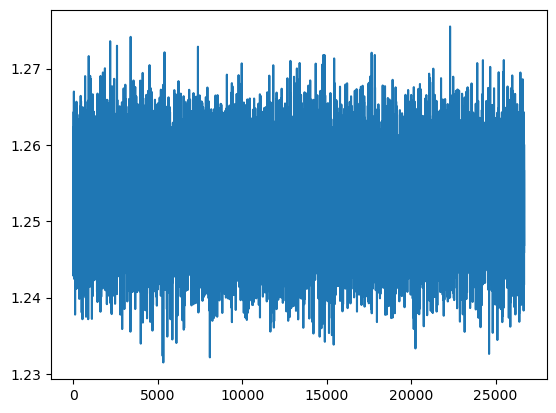

In [31]:
plt.plot(mse_list)

In [32]:
pre = model_car(x_torch[0,:,:])

In [33]:
y_torch[step-1,:,:]

NameError: name 'step' is not defined

In [65]:
pre

tensor([[ 1.4561],
        [ 1.4258],
        [ 1.4277],
        [ 1.4272],
        [ 1.4517],
        [ 1.4817],
        [ 1.5301],
        [ 1.5514],
        [ 1.5177],
        [ 1.5066],
        [ 1.4965],
        [ 1.5339],
        [ 1.5610],
        [ 1.5579],
        [ 1.5534],
        [ 1.5375],
        [ 1.5032],
        [ 1.4630],
        [ 1.4728],
        [ 1.4608],
        [ 1.4283],
        [ 1.4139],
        [ 1.4237],
        [ 1.4626],
        [ 1.4737],
        [ 1.4735],
        [ 1.4821],
        [ 1.4921],
        [ 1.4919],
        [ 1.4905],
        [ 1.4636],
        [ 1.4850],
        [ 1.4955],
        [ 1.4629],
        [ 1.4759],
        [ 1.4821],
        [ 1.5006],
        [ 1.5019],
        [ 1.5347],
        [ 1.4971],
        [ 1.4792],
        [ 1.4626],
        [ 1.4527],
        [ 1.4316],
        [ 1.4273],
        [ 1.3868],
        [ 1.3355],
        [ 1.3588],
        [ 1.3503],
        [ 1.3116],
        [ 1.3155],
        [ 1.3404],
        [ 1.

In [59]:
rel_mse_list=[]
mse_list=[]
for epoch in range(1000):
    for start in range(1, 1000, 25):
    
        end=min(start + 25, 1000)
        batch_x = x_torch[start:end, :,:]
        batch_y = y_torch[start:end, :,:]
          
        pre = model_car(batch_x)

        mse = mse_loss(pre,batch_y.T)
        lk=kl_loss(model_car)
        cost = mse + kl_weight*lk 
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        rel_mse_list.append(mean_rel_mse)
        mse_list.append(mean_mse)
    
    
print('- MSE : %2.5f, KL : %2.5f' % (mse.item(), lk.item()))

RuntimeError: running_mean should contain 601 elements not 10

In [45]:
cost


tensor([1.3171], grad_fn=<AddBackward0>)

In [49]:
x_torch.shape

torch.Size([1000, 601, 2])

In [50]:
y_torch.shape

torch.Size([1000, 1, 601])

### Normal NNs

In [52]:
rel_mse_list=[]
mse_list=[]
for epoch in range(1000):
    mse_list_epochs=[]
    rel_mse_list_epochs=[]
    kl_loss_epochs=[]
    for start in range(1, 1000, 25):
        end=min(start + 25, 1000)
        batch_x = x_torch[start:end, :,:]
        batch_y = y_torch[start:end, :,:]
        
        
        pre = model_nn(batch_x)
            
        #print(pre)
        #nump_pre=pre.detach().numpy()
        #print(nump_pre)
        #nump_target=(y_torch[step-1,:,:].T).detach().numpy()

        mse = mse_loss(pre,y_torch[start-1,:,:].T)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
            
        mse_list.append(mse)
    
    
print('- MSE : %2.5f' % (mse.item()))

RuntimeError: running_mean should contain 601 elements not 10

In [ ]:
kl

In [27]:
mse_list[-1]

1.3154565048217775

In [28]:
min(rel_mse_list)

2.0068487548828124

In [29]:
min(mse_list)

1.2753806447982787

In [30]:
num_layers = len(list(model_car.children()))
model_info = {
    'num_layers': num_layers,
    'units_per_layer': [1,10,1],
    'mse_loss': mse_loss,
    'mse_list': mse_list,
    'rel_mse_list': rel_mse_list,
    'rel_mse_loss': rel_mse,
    'min_loss': min(mse_list),
    'min_rel_mse': min(rel_mse_list),
    'kl_divergence': kl,
    'kl_weight': kl_weight,
    'learning_rate': lr
}

In [31]:
direct

'C:\\Users\\ad3389\\OneDrive - Northern Arizona University\\Desktop\\BNN_Multi_fidelity_TL\\logs'

In [32]:
def log_information_with_loss_list(log_file, model_info,direct):
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
        
        file.write('\n' * 5)
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")
        file.write(f"mse_list: {model_info['mse_list']}\n")
        file.write(f"rel_mse_list: {model_info['rel_mse_list']}\n")

        print("Log file created successfully.")



In [33]:
def log_information(log_file, model_info,direct):
    
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")


        print("Log file created successfully.")



In [34]:
log_information_with_loss_list('log_{}_loss_list.txt'.format(today_date), model_info,direct)

Log file created successfully.


In [35]:
log_information('log_{}.txt'.format(today_date), model_info,direct)

Log file created successfully.


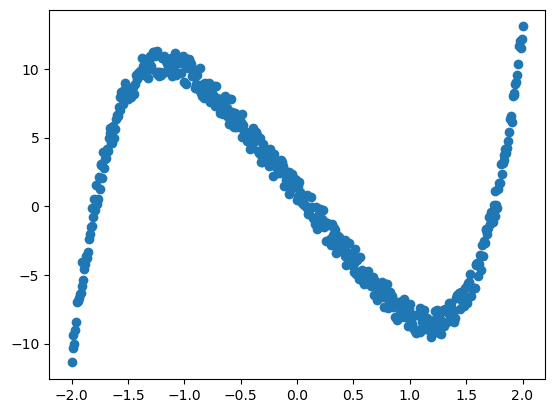

In [17]:
x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [18]:
x.shape

torch.Size([500, 1])

In [19]:
y.shape

torch.Size([500, 1])